In [1]:
import warnings
import os
warnings.filterwarnings("ignore") 

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
import pandas as pd
import pysam
import tensorflow as tf
from basenji import seqnn, stream
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")

from akita_utils.dna_utils import dna_1hot
from akita_utils.seq_gens import central_permutation_seqs_gen
from akita_utils.numpy_utils import ut_dense

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
# arguments 
genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 
stats = "SCD"
batch_size=8
head_index = 1
model_index = 1
shifts = "0"
rc = False
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")
chrom_sizes = "/project/fudenber_735/genomes/mm10/mm10.fa.sizes"

# tsv with coordinates of 10 strong sites randomly chosed from the 4 percentiles of sites (wrt single insertion score)
CTCT_table = "./high_disruption_scores.tsv"

models_dir="/project/fudenber_735/tensorflow_models/akita/v2/models"
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"
print("params_file: ", params_file)
print("model_file: ", model_file)

chrom_sizes_table = pd.read_csv(chrom_sizes, sep="\t", names=["chrom", "size"])

params_file:  /project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/params.json
model_file:  /project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/model1_best.h5


### Loading the model

In [4]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

### Readimg a table with insertion parameters

In [5]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

In [6]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")
seq_coords_df = seq_coords_df[["chrom", "end", "start", "strand"]]
seq_coords_df = seq_coords_df.copy()
seq_coords_df["seq_index"] = [i for i in range(len(seq_coords_df))]
num_experiments = len(seq_coords_df)

In [7]:
preds_stream = stream.PredStreamGen(
        seqnn_model,
        central_permutation_seqs_gen(seq_coords_df, genome_open, chrom_sizes_table),
        batch_size,
    )

3/3 [==============================] - 21s 6s/step
Experiment index:  0
reference


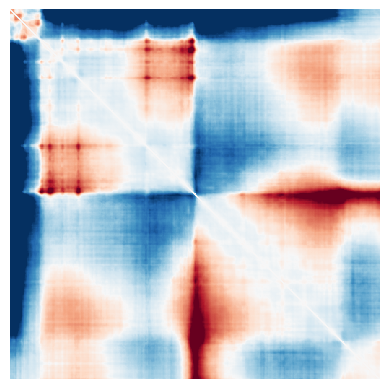

permuted


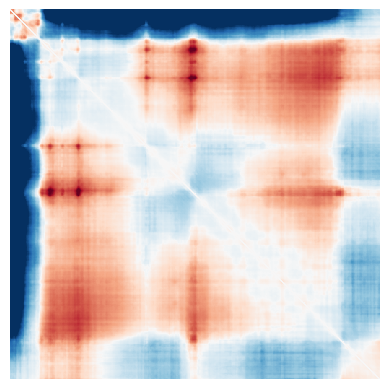

Experiment index:  1
reference


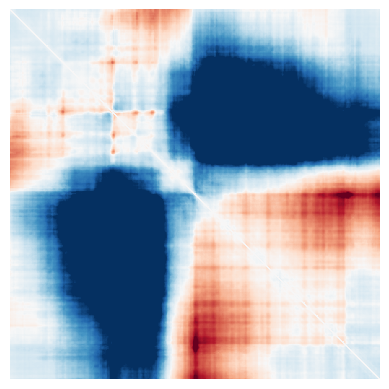

permuted


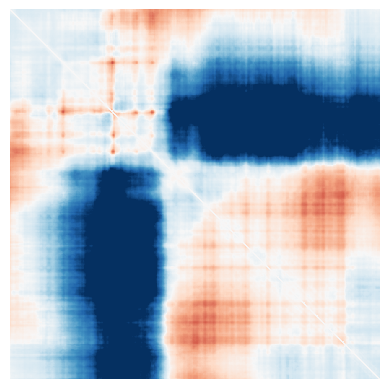

Experiment index:  2
reference


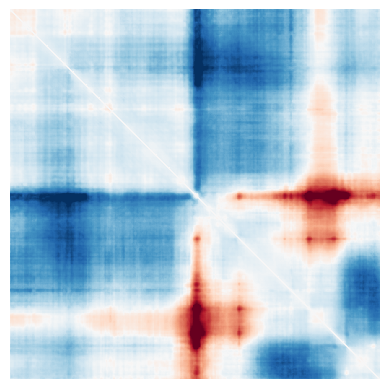

permuted


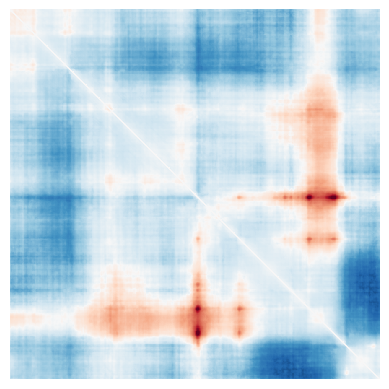

Experiment index:  3
reference


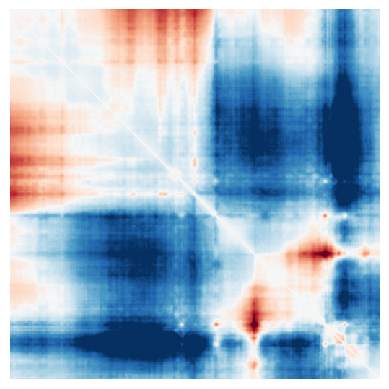

permuted


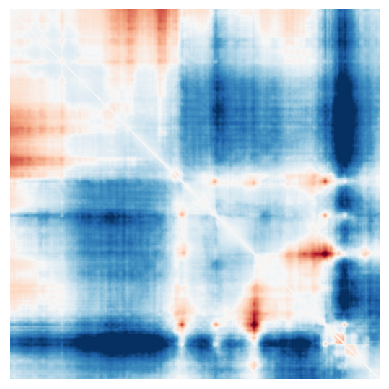

Experiment index:  4
reference


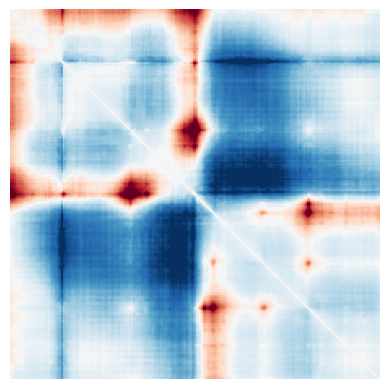

permuted


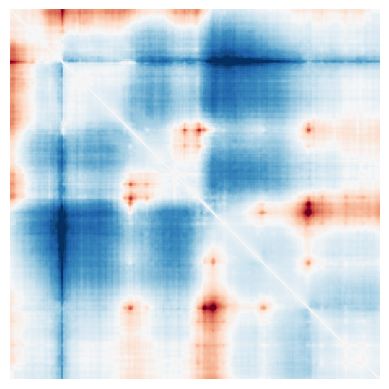

Experiment index:  5
reference


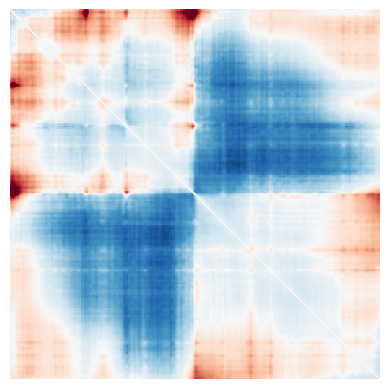

permuted


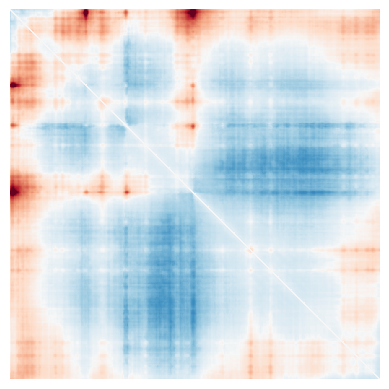

Experiment index:  6
reference


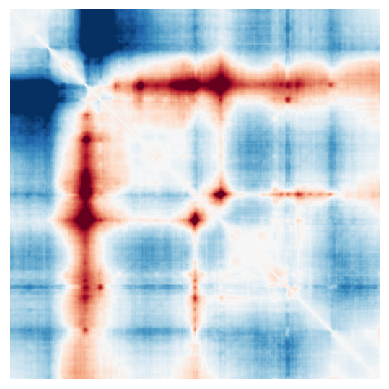

permuted


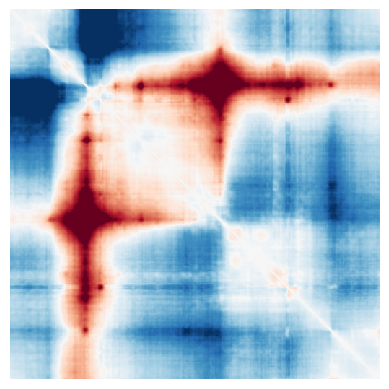

Experiment index:  7
reference


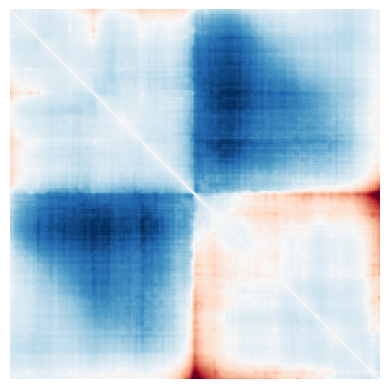

permuted


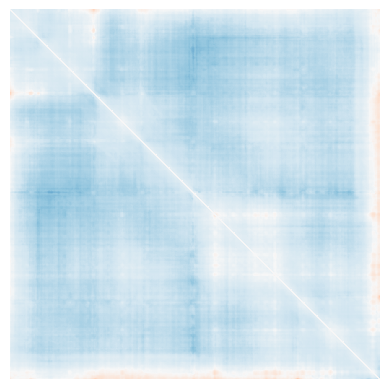

Experiment index:  8
reference


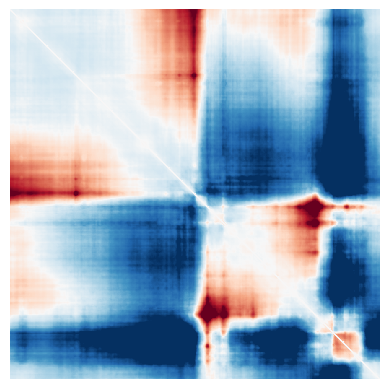

permuted


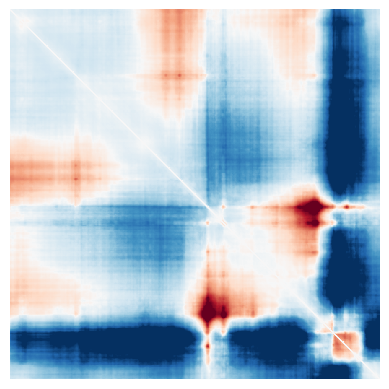

Experiment index:  9
reference


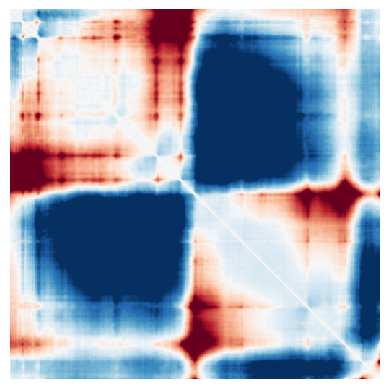

permuted


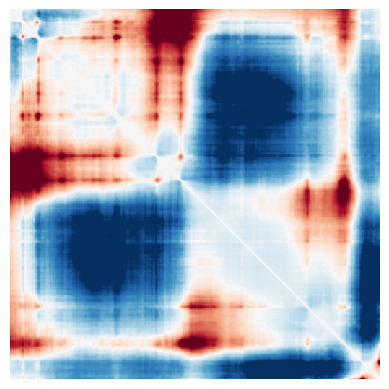

In [8]:
for ref_index in range(0, num_experiments*2, 2):
    
    ref_preds_matrix = preds_stream[ref_index]
    permut_index = ref_index + 1
    permuted_preds_matrix = preds_stream[permut_index]
    exp_index = ref_index//2

    ref_maps = ut_dense(ref_preds_matrix)
    perm_maps = ut_dense(permuted_preds_matrix)

    print("Experiment index: ", exp_index)

    # plot_map
    print("reference")
    sns.heatmap(
        ref_maps[:,:,0],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
    )
    # plt.savefig(f"./example_plots/example_disruption_ref_{exp_index}.pdf", format="pdf", bbox_inches="tight")
    plt.savefig(f"./example_plots/example_disruption_ref_{exp_index}.png", format="png", bbox_inches="tight")
    plt.show()
    
    print("permuted")
    sns.heatmap(
        perm_maps[:,:,0],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
    )
    # plt.savefig(f"./example_maps/example_disruption_perm_{exp_index}.pdf", format="pdf", bbox_inches="tight")
    plt.savefig(f"./example_maps/example_disruption_perm_{exp_index}.png", format="png", bbox_inches="tight")
    plt.show()

In [9]:
genome_open.close()